In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [14]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [15]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [16]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [17]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [18]:
# Save references to each table
Measurement = Base.classes.measurement

Station = Base.classes.station

In [19]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [80]:
# Inspector to check the Tables and columns
inspector = inspect(engine)

# Measearement Table
m_col = inspector.get_columns("measurement")
for header in m_col:
    print(header["name"], header["type"])
    
print("--"*5)

# Station Table
s_col = inspector.get_columns("station")
for header in s_col:
    print(header["name"], header["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
----------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [36]:
# Find the most recent date in the data set.
recent_date =  session.query(Measurement.date).order_by(Measurement.date.desc()).first().date
f'The most recent date in dataset is : {recent_date}'

'The most recent date in dataset is : 2017-08-23'

In [58]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
date_oneyearago = dt.date(2017, 8, 23) - dt.timedelta(days = 365)
f'The date one year ago is : {date_oneyearago}'

# Perform a query to retrieve the data and precipitation scores
prcp_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= date_oneyearago).all()

# Save the query results as a Pandas DataFrame 
prcp_df = pd.DataFrame(prcp_data, columns=["Date", "Precipitation"])
prcp_df


,Date,Precipitation
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00
...,...,...
2225,2017-08-19,0.09
2226,2017-08-20,NaN
2227,2017-08-21,0.56
2228,2017-08-22,0.50


In [60]:
# Sort the dataframe by date  
sorted_prcp_df = prcp_df.sort_values("Date")
sorted_prcp_df.head()


,Date,Precipitation
0,2016-08-23,0.00
1009,2016-08-23,NaN
1529,2016-08-23,1.79
704,2016-08-23,0.05
361,2016-08-23,0.15


In [61]:
# Set the index to the date column
date_indexed_df = sorted_prcp_df.set_index("Date")
date_indexed_df.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


In [63]:
# Check for the null values
date_indexed_df["Precipitation"].isnull().sum()

209

In [64]:
# Drop Nulls
clean_prcp_df = date_indexed_df.dropna(axis=0, how="any")
clean_prcp_df

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
2016-08-23,0.70
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


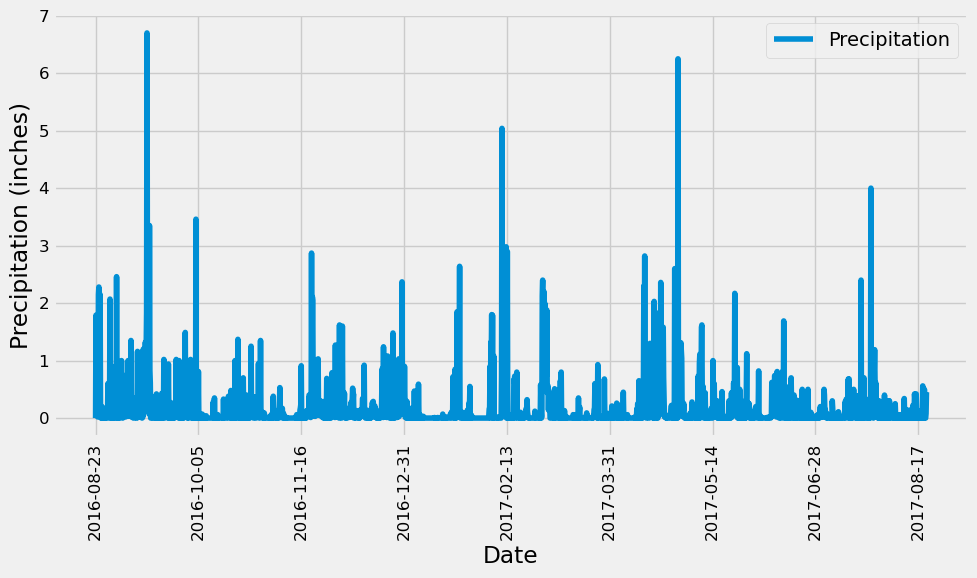

In [69]:
# Use Pandas Plotting with Matplotlib to plot the data
clean_prcp_df.plot(figsize=(10,6), fontsize=12, rot=90)
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.tight_layout()
plt.savefig("Images/prcp.png")
plt.show()

In [73]:
# Use Pandas to calcualte the summary statistics for the precipitation data
clean_prcp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [79]:
# Design a query to calculate the total number stations in the dataset
total_station = session.query(Station).count()
f"Total Stations : {total_station}"

'Total Stations : 9'

In [82]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_station = session.query(Measurement.station, func.count(Measurement.station)).\
                    order_by(func.count(Measurement.station).desc()).\
                    group_by(Measurement.station).all()
active_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [97]:
# The most active station 
most_active_station = active_station[0][0]
f"The most active station is : {most_active_station}"

'The most active station is : USC00519281'

In [120]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
lowest_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == most_active_station).scalar()
highest_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == most_active_station).scalar()
average_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station).scalar()
print(f"The most active station is : {most_active_station}")
print(f"----------------------------------------------------")
print(f"Lowest Temp : {lowest_temp}")
print(f"Highest Temp : {highest_temp}")
print(f"Average Temp : {round(average_temp, 2)}")

The most active station is : USC00519281
----------------------------------------------------
Lowest Temp : 54.0
Highest Temp : 85.0
Average Temp : 71.66


In [129]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_tobs = pd.DataFrame(session.query(Measurement.tobs).filter((Measurement.station == most_active_station) & (Measurement.date >= date_oneyearago)).all())
most_active_tobs

,tobs
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0
...,...
347,77.0
348,77.0
349,76.0
350,76.0


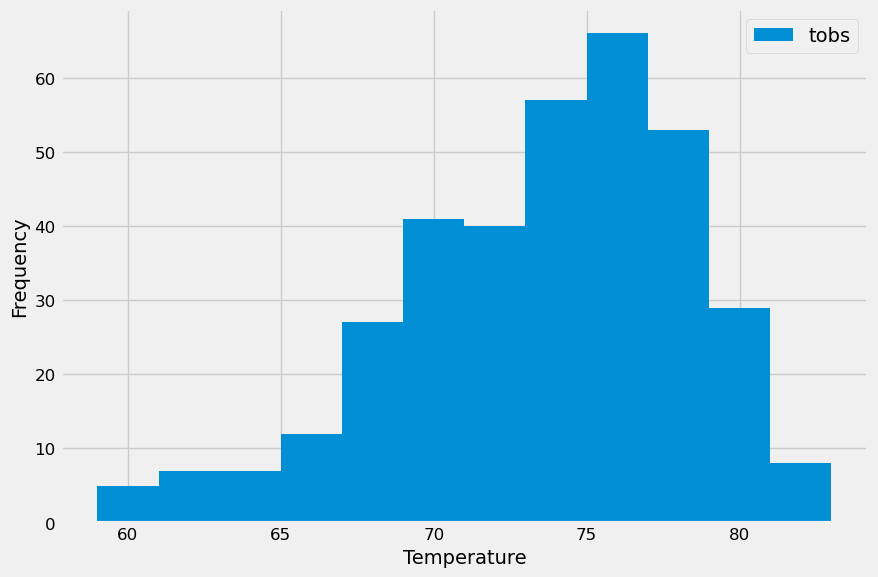

In [132]:
most_active_tobs.plot(kind="hist", figsize=(9,6), bins=12, legend=True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Temperature", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.tight_layout()
plt.savefig("Images/tobs.png")
plt.show()

# Close session

In [133]:
# Close Session
session.close()